# Model different Climate Scenarios

## 1. regridding
https://climate-cms.org/posts/2021-11-02-pyproj-regrid.html
https://py-cordex.readthedocs.io/en/stable/domains.html
https://stackoverflow.com/questions/70997075/using-xarray-interp-to-reproject-a-dataarray
https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html

## 2. 

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyproj

# import xesmf

In [2]:
def open_files(file_dir, varname):
    
    files = os.listdir(file_dir)
    
    ds = xr.Dataset()
    for file in sorted(files):
        var = xr.open_dataset(os.path.join(file_dir, file))
        crs = var.crs
        monthly_mean = var[varname].resample(time='1M', label='right').mean()
        ds = xr.merge([ds, monthly_mean])
        
    return ds, crs

In [3]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [4]:
varname = 'tasmax'

saobs_filename = 'tx_0.25deg_reg_v2.0_saobs.nc.gz'
saobs_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data', 'sa-obs')
cordex_path_hist = os.path.join(os.sep, 'rdsi', 'climatefutures', 'private', 'WINE', 'output', 'SEA-22', 'ICTP', 'IPSL-IPSL-CM5A-LR', 'historical', 'r1i1p1', 'ICTP-RegCM4-3', 'v4', 'day', varname)
# cordex_path_rcp85 = os.path.join(os.sep, 'rdsi', 'climatefutures', 'private', 'WINE', 'output', 'SEA-22', 'ICTP', 'NOAA-GFDL-GFDL-ESM2M', 'rcp85', 'r1i1p1', 'ICTP-RegCM4-3', 'v4', 'day', 'tasmax')
os.path.exists(saobs_path), os.path.exists(cordex_path_hist)

(True, True)

In [5]:
ds, crs = open_files(cordex_path_hist, varname)
obs = xr.open_dataset(os.path.join(saobs_path, saobs_filename))

In [15]:
obs

<xarray.Dataset>
Dimensions:    (longitude: 400, latitude: 201, time: 13514)
Coordinates:
  * longitude  (longitude) float32 80.12 80.38 80.62 80.88 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -24.88 -24.62 -24.38 ... 24.62 24.88 25.12
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    tx         (time, latitude, longitude) float32 ...
Attributes:
    Version:                   2.0
    Conventions:               CF-1.4
    References:                http://www.ecad.eu\nhttp://www.ecad.eu/downloa...
    history:                   Tue Aug 28 15:06:46 2018: ncks -a --fix_rec_dm...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

In [6]:
# select obs data in SEA-22 domain
lon_lim = slice(float(np.unique(ds.lon[::,0])), float(np.unique(ds.lon[::,-1])))
lat_lim = slice(float(np.unique(ds.lat[0])), float(np.unique(ds.lat[-1])))

obs_sel = obs.sel(longitude=lon_lim, latitude=lat_lim)

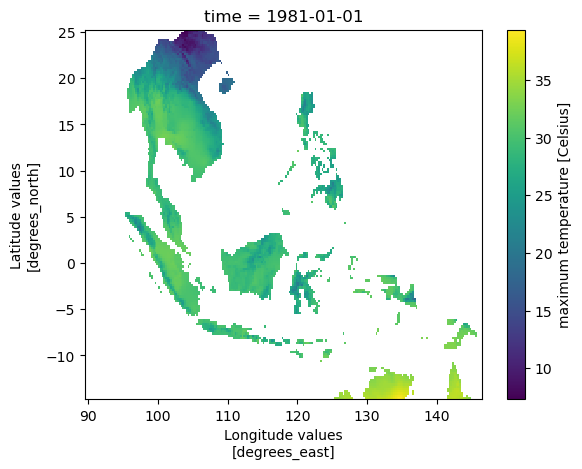

In [7]:
obs_sel.tx.isel(time=0).plot()

In [8]:
# source_crs = pyproj.CRS.from_cf(crs.attrs)
source_crs = pyproj.CRS(init="epsg:3832")
target_crs = pyproj.CRS(init="epsg:4326")

cartesian_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
latlon_to_cartesian = pyproj.Transformer.from_crs(target_crs, source_crs, always_xy=True)

/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
tx = obs_sel.tx.isel(time=0)

In [10]:
lonmesh, latmesh = np.meshgrid(tx.longitude, tx.latitude)

In [11]:
x_obs, y_obs = latlon_to_cartesian.transform(lonmesh, latmesh)
# x, y = latlon_to_cartesian.transform([tx.longitude.min(),tx.longitude.max()], [tx.latitude.min(),tx.latitude.max()])
# x, y

In [12]:
x_obs = xr.DataArray(x_obs, dims=['y', 'x'], coords=[y_obs[::,0], x_obs[0,]])
y_obs = xr.DataArray(y_obs, dims=['y', 'x'], coords=[y_obs[::,0], x_obs[0,]])

In [13]:
tx_xy = tx.interp({'longitude': x_obs, 'latitude': y_obs}, method='linear').load()

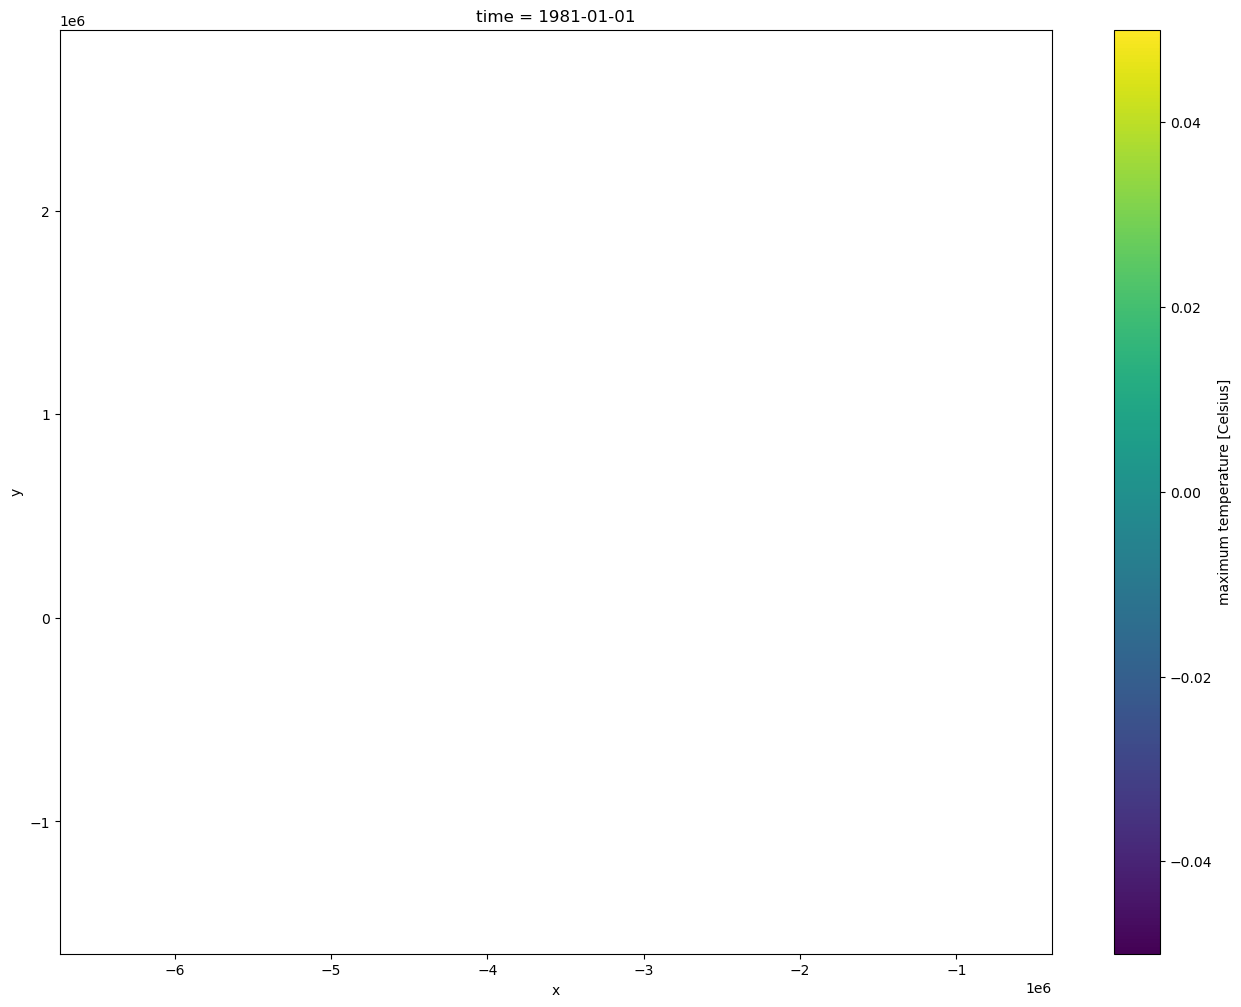

In [14]:
tx_xy.plot(size=12);

In [6]:
ds, obs

(<xarray.Dataset>
 Dimensions:  (x: 253, y: 191, time: 672)
 Coordinates:
   * x        (x) float64 -3.15e+06 -3.125e+06 -3.1e+06 ... 3.125e+06 3.15e+06
   * y        (y) float64 -2.375e+06 -2.35e+06 -2.325e+06 ... 2.35e+06 2.375e+06
   * time     (time) object 1950-01-31 00:00:00 ... 2005-12-31 00:00:00
     lat      (y, x) float64 -14.81 -14.81 -14.81 -14.81 ... 26.96 26.96 26.96
     lon      (y, x) float64 89.49 89.72 89.94 90.17 ... 145.8 146.1 146.3 146.5
     height   float64 2.0
 Data variables:
     tasmax   (time, y, x) float32 297.5 297.6 297.6 297.6 ... 292.9 292.9 292.9,
 <xarray.Dataset>
 Dimensions:    (longitude: 400, latitude: 201, time: 13514)
 Coordinates:
   * longitude  (longitude) float32 80.12 80.38 80.62 80.88 ... 179.4 179.6 179.9
   * latitude   (latitude) float32 -24.88 -24.62 -24.38 ... 24.62 24.88 25.12
   * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
 Data variables:
     tx         (time, latitude, longitude) float32 ...
 Attribu

In [25]:
ds_lon = xr.DataArray(ds.lon.values, dims=('lat','lon'))
ds_lat = xr.DataArray(ds.lat.values, dims=('lat','lon'))

In [26]:
# interp cordex data on latlon grid
cdx_latlon = ds.interp({'x': ds_lon, 'y': ds_lat}, method='linear').load()

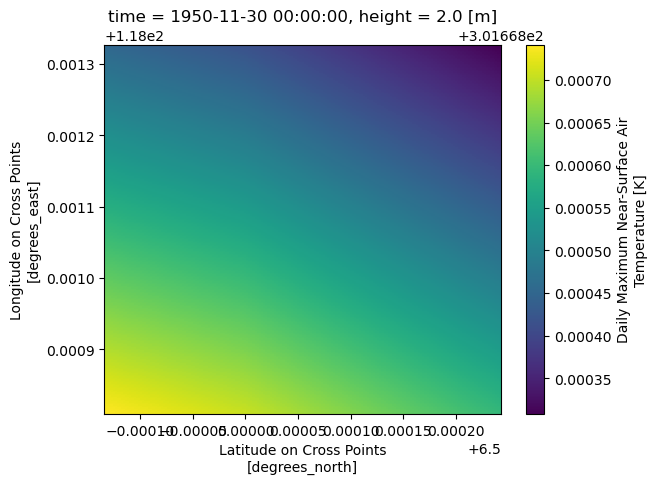

In [27]:
cdx_latlon.tasmax.isel(time=10).plot()

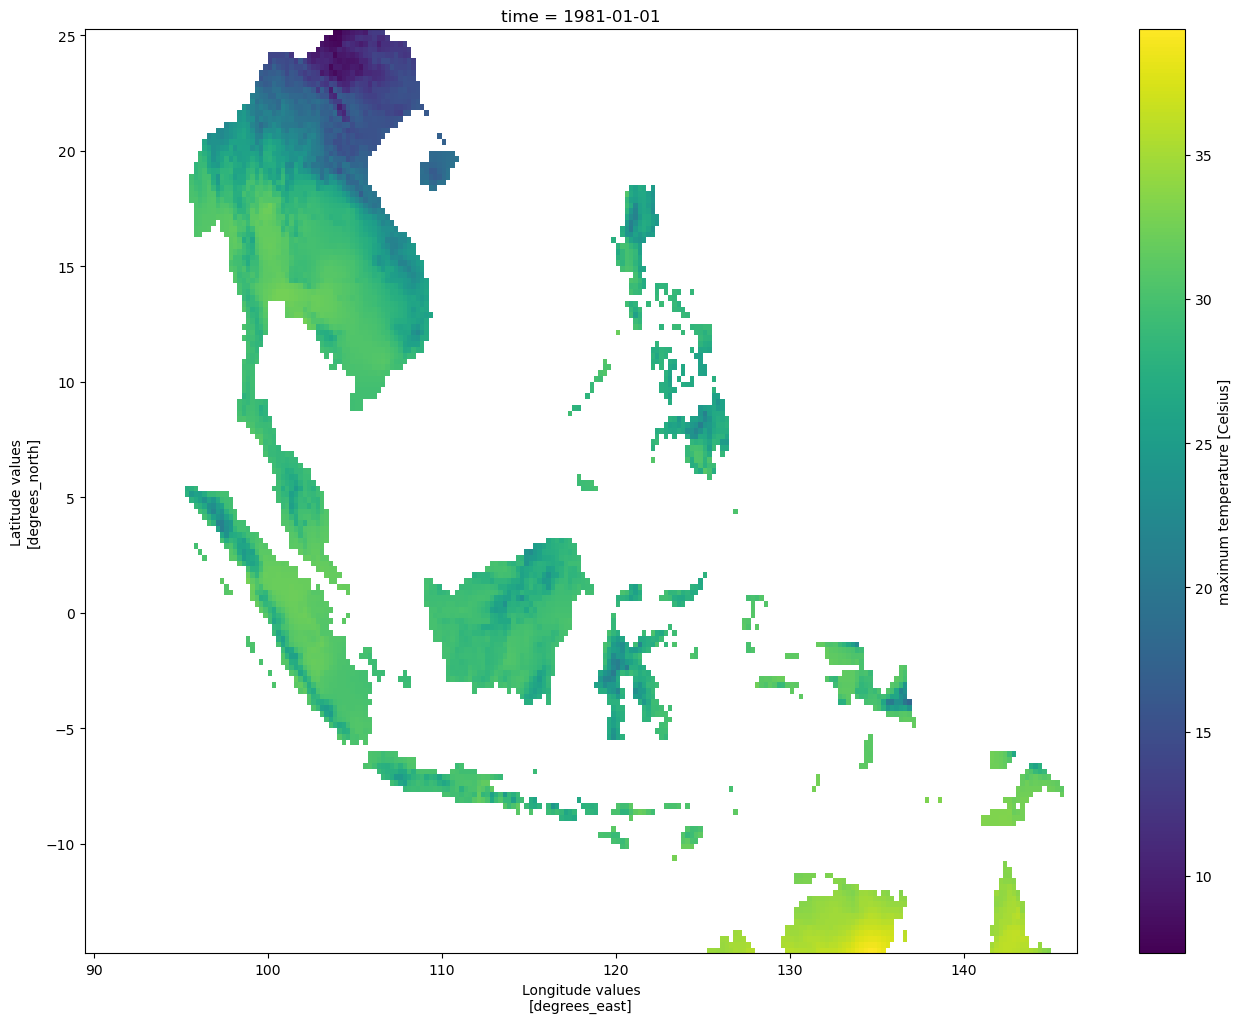

In [95]:
tx.plot(size=12);

In [19]:
lonmesh, latmesh = ds['lon'].values, ds['lat'].values

In [20]:
lonmesh

array([[ 89.48911285,  89.71539307,  89.94166565, ..., 146.05833435,
        146.28460693, 146.51087952],
       [ 89.48911285,  89.71539307,  89.94166565, ..., 146.05833435,
        146.28460693, 146.51087952],
       [ 89.48911285,  89.71539307,  89.94166565, ..., 146.05833435,
        146.28460693, 146.51087952],
       ...,
       [ 89.48911285,  89.71539307,  89.94166565, ..., 146.05833435,
        146.28460693, 146.51087952],
       [ 89.48911285,  89.71539307,  89.94166565, ..., 146.05833435,
        146.28460693, 146.51087952],
       [ 89.48911285,  89.71539307,  89.94166565, ..., 146.05833435,
        146.28460693, 146.51087952]])

In [21]:
lon = xr.DataArray(lonmesh, dims=('lat', 'lon'))
lat = xr.DataArray(latmesh, dims=('lat','lon'))

In [22]:
ds_latlon = ds.interp({'lon': lon, 'lat': lat}, method='nearest').load()

ValueError: Dimensions {'lat', 'lon'} do not exist. Expected one or more of Frozen({'x': 253, 'y': 191, 'time': 672})

/opt/anaconda3/envs/aciar/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
import cordex as cx


ModuleNotFoundError: No module named 'cordex'

In [10]:
cx.domain_info("EUR-11")

NameError: name 'cx' is not defined

/opt/anaconda3/envs/xclim/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [154]:
X, Y = np.meshgrid(ds.x, ds.y)
lon, lat = cartesian_to_latlon.transform(X, Y)

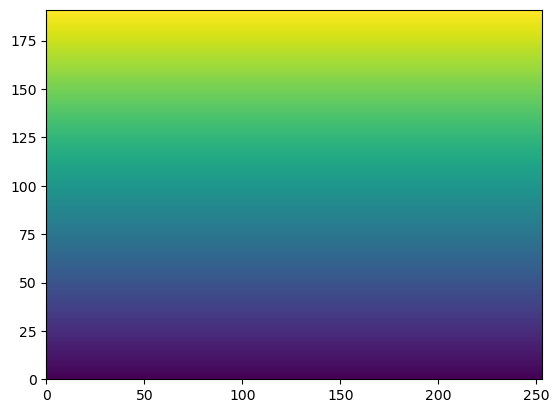

In [155]:
plt.pcolormesh(lat)

In [156]:
lon_cdx = xr.DataArray(lon, dims=('latt', 'lont'))
lat_cdx = xr.DataArray(lat, dims=('latt', 'lont'))

In [169]:
lat_cdx[::,0]

<xarray.DataArray (latt: 191)>
array([-20.90339215, -20.69185955, -20.48003157, -20.26791069,
       -20.05549942, -19.84280027, -19.62981581, -19.41654858,
       -19.20300118, -18.98917621, -18.77507628, -18.56070404,
       -18.34606215, -18.13115328, -17.91598013, -17.70054541,
       -17.48485186, -17.26890221, -17.05269925, -16.83624575,
       -16.61954452, -16.40259837, -16.18541015, -15.96798271,
       -15.75031892, -15.53242166, -15.31429385, -15.09593839,
       -14.87735824, -14.65855634, -14.43953566, -14.22029919,
       -14.00084992, -13.78119088, -13.56132509, -13.3412556 ,
       -13.12098547, -12.90051777, -12.67985561, -12.45900207,
       -12.23796028, -12.01673337, -11.79532449, -11.5737368 ,
       -11.35197346, -11.13003767, -10.90793262, -10.68566153,
       -10.46322761, -10.2406341 , -10.01788425,  -9.79498133,
        -9.57192859,  -9.34872932,  -9.12538682,  -8.90190439,
        -8.67828534,  -8.454533  ,  -8.23065071,  -8.0066418 ,
        -7.78250963,  -7.55825757,  -7.33388899,  -7.10940727,
        -6.8848158 ,  -6.66011798,  -6.43531722,  -6.21041693,
        -5.98542053,  -5.76033147,  -5.53515316,  -5.30988906,
        -5.08454261,  -4.85911728,  -4.63361653,  -4.40804382,
        -4.18240263,  -3.95669645,  -3.73092874,  -3.50510301,
...
         3.95669645,   4.18240263,   4.40804382,   4.63361653,
         4.85911728,   5.08454261,   5.30988906,   5.53515316,
         5.76033147,   5.98542053,   6.21041693,   6.43531722,
         6.66011798,   6.8848158 ,   7.10940727,   7.33388899,
         7.55825757,   7.78250963,   8.0066418 ,   8.23065071,
         8.454533  ,   8.67828534,   8.90190439,   9.12538682,
         9.34872932,   9.57192859,   9.79498133,  10.01788425,
        10.2406341 ,  10.46322761,  10.68566153,  10.90793262,
        11.13003767,  11.35197346,  11.5737368 ,  11.79532449,
        12.01673337,  12.23796028,  12.45900207,  12.67985561,
        12.90051777,  13.12098547,  13.3412556 ,  13.56132509,
        13.78119088,  14.00084992,  14.22029919,  14.43953566,
        14.65855634,  14.87735824,  15.09593839,  15.31429385,
        15.53242166,  15.75031892,  15.96798271,  16.18541015,
        16.40259837,  16.61954452,  16.83624575,  17.05269925,
        17.26890221,  17.48485186,  17.70054541,  17.91598013,
        18.13115328,  18.34606215,  18.56070404,  18.77507628,
        18.98917621,  19.20300118,  19.41654858,  19.62981581,
        19.84280027,  20.05549942,  20.26791069,  20.48003157,
        20.69185955,  20.90339215,  21.11462689])
Dimensions without coordinates: latt

In [157]:
ds_cdx = ds.interp({'x': lon_cdx, 'y': lat_cdx}).load()


In [171]:
ds_cdx = ds_cdx.assign_coords({'lont': lon_cdx[0], 'latt': lat_cdx[::,0]})

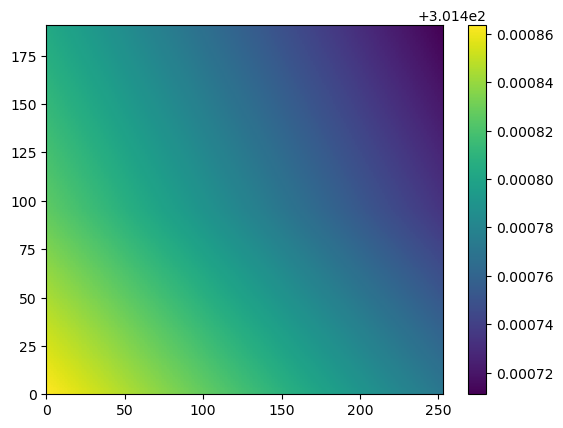

In [177]:
pcol = plt.pcolormesh(ds_cdx.tasmax.isel(time=0).values)
plt.colorbar(pcol)

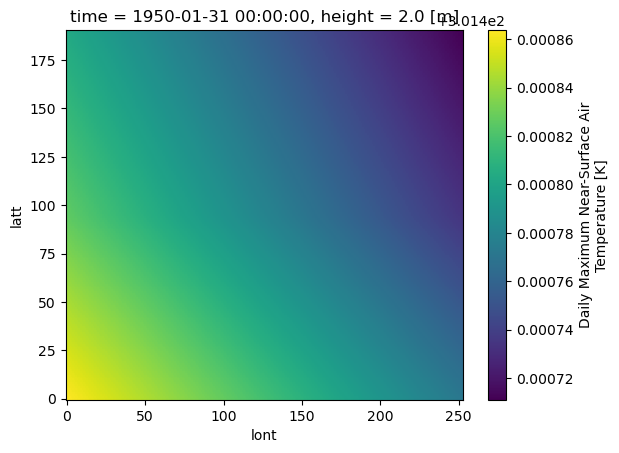

In [159]:
ds_cdx.tasmax.isel(time=0).plot()

In [6]:
obs = xr.open_dataset(os.path.join(saobs_path, saobs_filename))

In [104]:
obs_t0 = obs.tx.isel(time=0).fillna(10)
# obs_t0.plot()

In [107]:
obs_t0.longitude

<xarray.DataArray 'longitude' (longitude: 400)>
array([ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 80.12 80.38 80.62 80.88 ... 179.4 179.6 179.9
    time       datetime64[ns] 1981-01-01
Attributes:
    long_name:      Longitude values
    units:          degrees_east
    standard_name:  longitude

In [108]:
latmesh

array([[ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875],
       [ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875],
       [ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875],
       ...,
       [ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875],
       [ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875],
       [ 80.125,  80.375,  80.625, ..., 179.375, 179.625, 179.875]],
      dtype=float32)

In [114]:


latlon_to_xy = pyproj.Transformer.from_crs(source_crs, target_crs)

lonmesh, latmesh  = np.meshgrid(obs_t0.longitude, obs_t0.latitude)

xobs, yobs = latlon_to_xy.transform(latmesh, lonmesh)

xobs = xr.DataArray(xobs, dims=('y', 'x'))
yobs = xr.DataArray(yobs, dims=('y', 'x'))

obs_cdx = obs_t0.interp({'longitude': xobs, 'latitude': yobs}, method='linear').load()
obs_cdx = obs_cdx.assign_coords({'x': xobs[:,0], 'y': yobs[0]})

/opt/anaconda3/envs/xclim/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/envs/xclim/lib/python3.10/site-packages/scipy/interpolate/interpolate.py:2546: RuntimeWarning: invalid value encountered in add
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


/opt/anaconda3/envs/xclim/lib/python3.10/site-packages/numpy/lib/function_base.py:1292: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

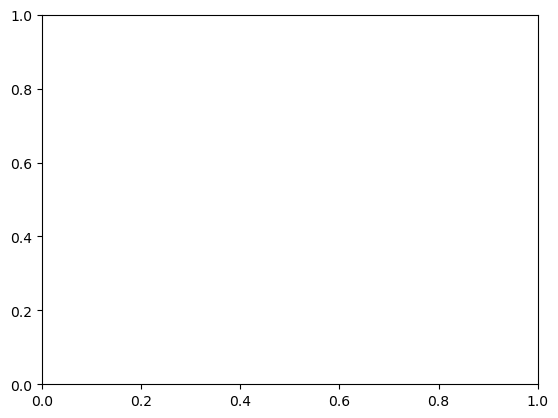

In [115]:
obs_cdx.plot()

In [40]:

# crs = xr.open_dataset(os.path.join(cordex_path_hist, os.listdir(cordex_path_hist)[0])).crs


lonmesh, latmesh = np.meshgrid(ds.x, ds.y)

x_om2, y_om2 = latlon_to_polar.transform(lonmesh, latmesh)
x_om2 = xr.DataArray(x_om2, dims=('lat','lon'))
y_om2 = xr.DataArray(y_om2, dims=('lat','lon'))

In [41]:
data_om2 = data.drop_vars('mapping').interp({'x':x_om2, 'y':y_om2}, method='nearest').load()

<Derived Projected CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: undefined
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant B)
Datum: undefined
- Ellipsoid: undefined
- Prime Meridian: Greenwich

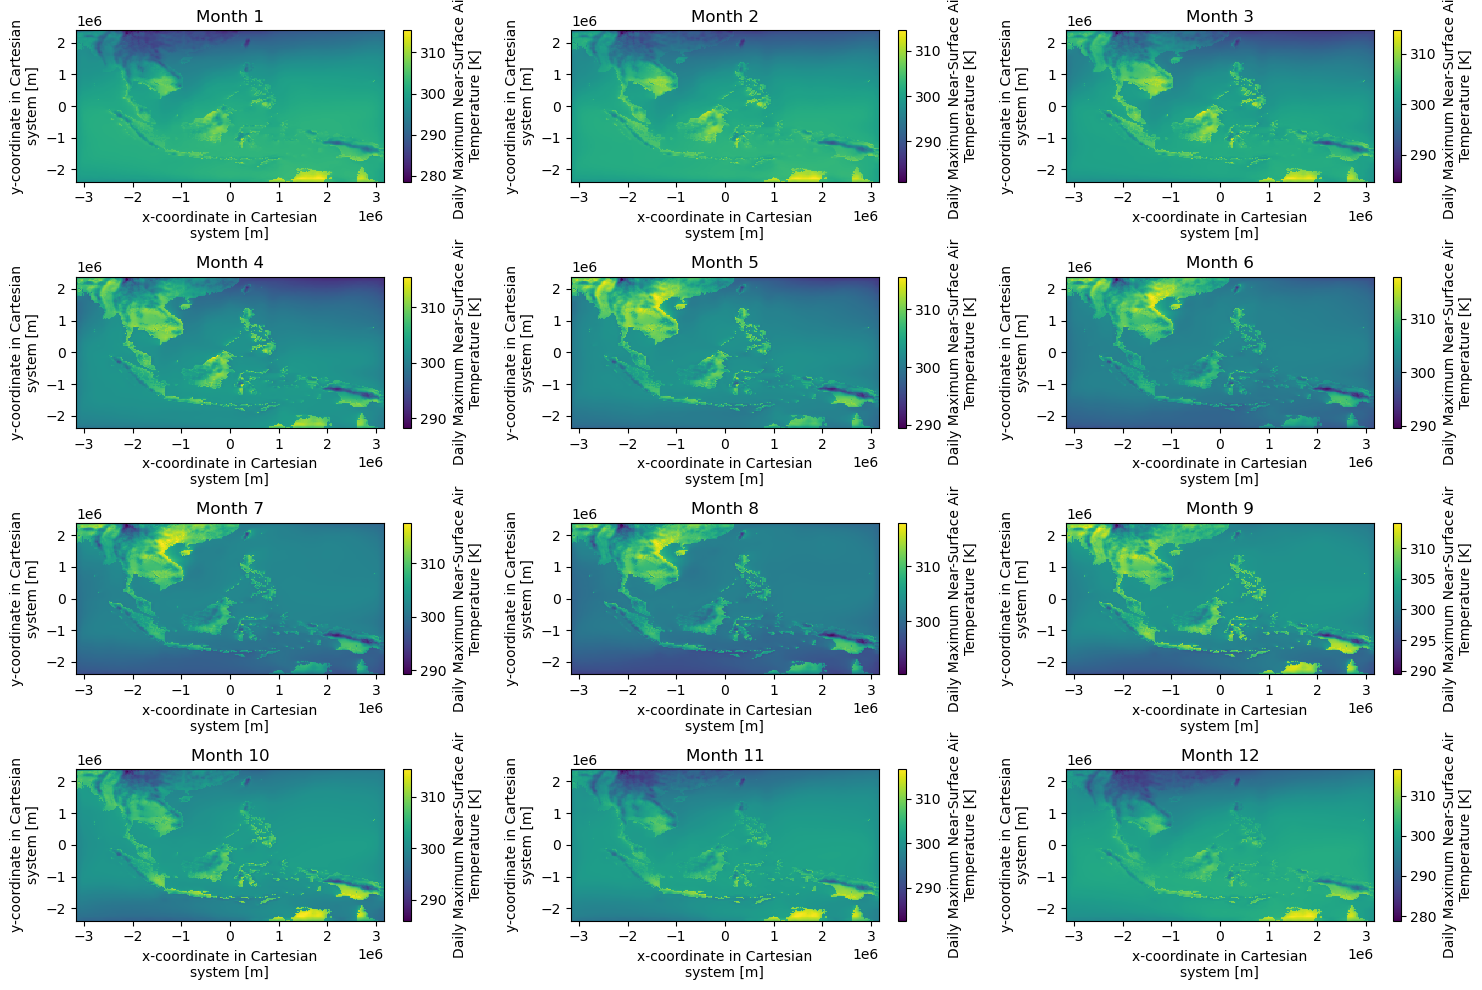

In [8]:
# Calculate monthly mean over the entire time period
monthly_mean = ds.groupby('time.month').mean(dim='time')

# Create subplots for each month
fig, axs = plt.subplots(4, 3, figsize=(15, 10))  # 4 rows, 3 columns for each month

# Iterate through each month and plot its mean
for month, ax in zip(range(1, 13), axs.flat):
    monthly_mean.sel(month=month)['tasmax'].plot(ax=ax)
    ax.set_title(f'Month {month}')

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
obs = xr.open_dataset(os.path.join(saobs_path, saobs_filename))

In [18]:
ds_obs= obs.resample(time='1M', label='right').mean()

In [30]:
ds_obs

<xarray.Dataset>
Dimensions:    (longitude: 400, latitude: 201, time: 444)
Coordinates:
  * longitude  (longitude) float32 80.12 80.38 80.62 80.88 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -24.88 -24.62 -24.38 ... 24.62 24.88 25.12
  * time       (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2017-12-31
Data variables:
    tx         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Version:                   2.0
    Conventions:               CF-1.4
    References:                http://www.ecad.eu\nhttp://www.ecad.eu/downloa...
    history:                   Tue Aug 28 15:06:46 2018: ncks -a --fix_rec_dm...
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1

In [33]:
lonmesh, latmesh = np.meshgrid(xt_ocean, yt_ocean)

<xarray.Dataset>
Dimensions:  (x: 253, y: 191, time: 672)
Coordinates:
  * x        (x) float64 -3.15e+06 -3.125e+06 -3.1e+06 ... 3.125e+06 3.15e+06
  * y        (y) float64 -2.375e+06 -2.35e+06 -2.325e+06 ... 2.35e+06 2.375e+06
  * time     (time) object 1950-01-31 00:00:00 ... 2005-12-31 00:00:00
    lat      (y, x) float64 -14.81 -14.81 -14.81 -14.81 ... 26.96 26.96 26.96
    lon      (y, x) float64 89.49 89.72 89.94 90.17 ... 145.8 146.1 146.3 146.5
    height   float64 2.0
Data variables:
    tasmax   (time, y, x) float32 297.5 297.6 297.6 297.6 ... 292.9 292.9 292.9

ValueError: x and y must be the same size

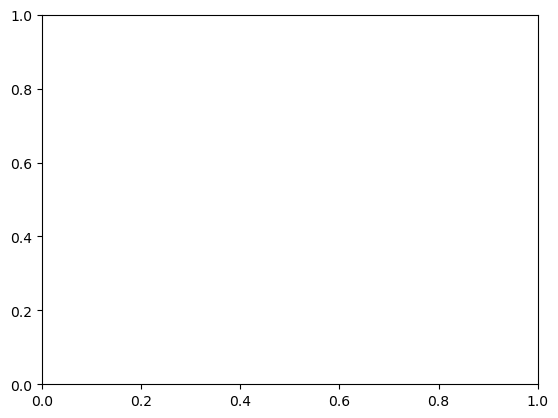

In [32]:
plt.scatter(ds_obs['longitude'], ds_obs['latitude'], s=0.01)  # plot grid locations

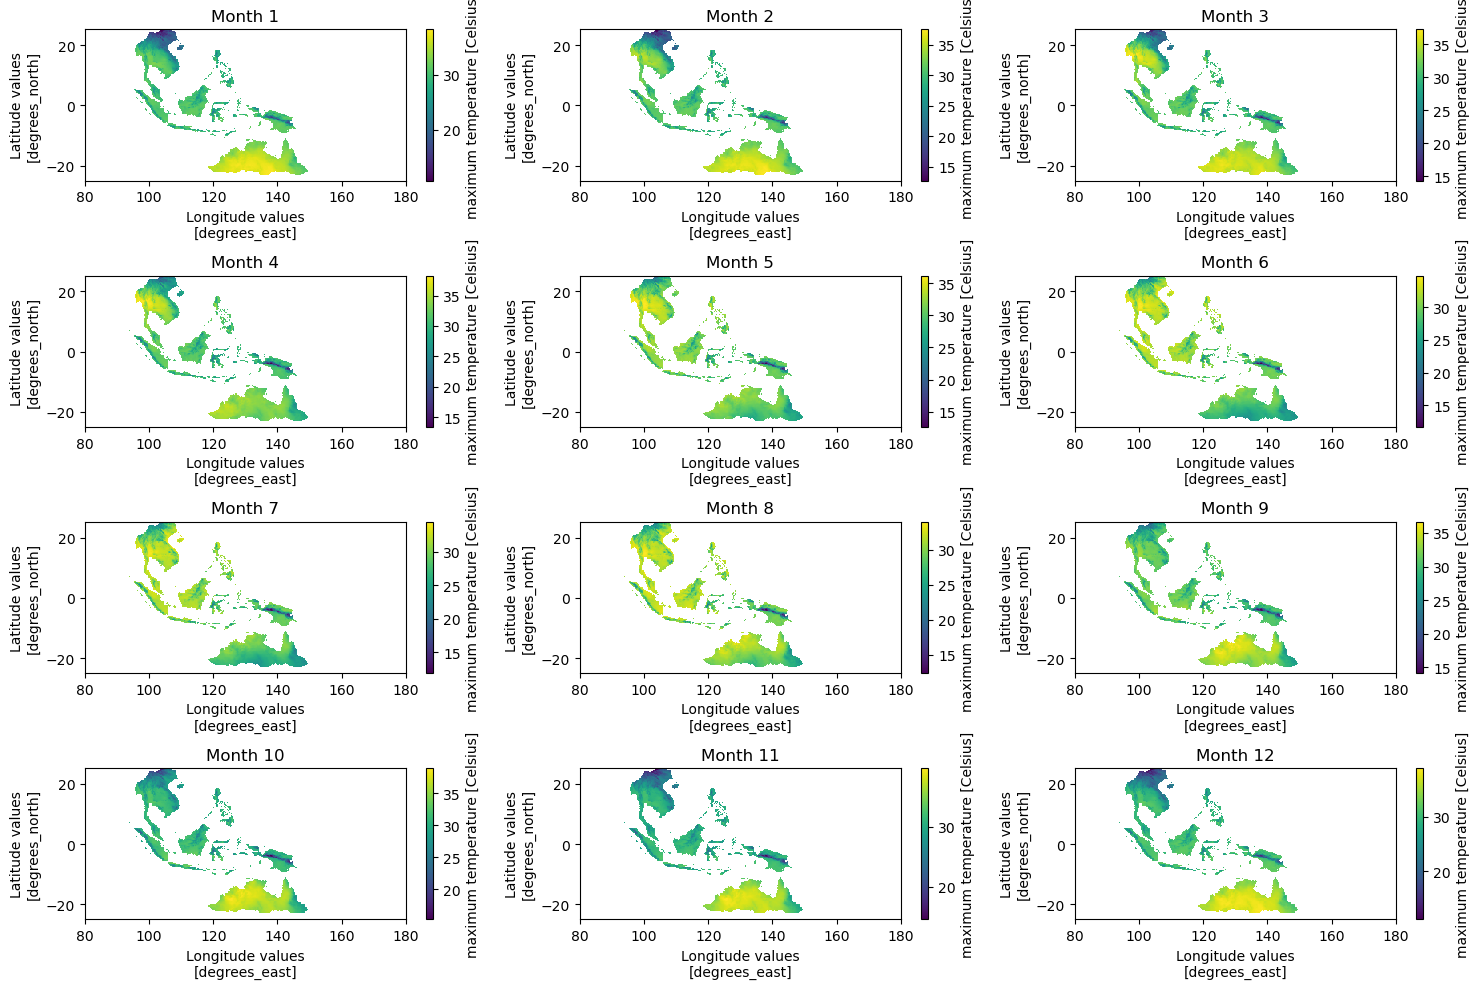

In [21]:
# Calculate monthly mean over the entire time period
monthly_mean = ds_obs.groupby('time.month').mean(dim='time')

# Create subplots for each month
fig, axs = plt.subplots(4, 3, figsize=(15, 10))  # 4 rows, 3 columns for each month

# Iterate through each month and plot its mean
for month, ax in zip(range(1, 13), axs.flat):
    monthly_mean.sel(month=month)['tx'].plot(ax=ax)
    ax.set_title(f'Month {month}')

# Adjust layout
plt.tight_layout()
plt.show()

In [29]:
import xgcm

ModuleNotFoundError: No module named 'xgcm'

In [27]:
ds.tasmax.gr

'crs'